### Preliminary imports

In [1]:
import numpy as np
import os
import pandas as pd
import scipy.io as sio
import seaborn as sns
import matplotlib.pyplot as plt
from feast import *

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
sns.set()
cwd = os.path.dirname(os.getcwd())
data_dir = os.path.join(os.path.dirname(os.getcwd()), 'data')
doc_dir = os.path.join(os.path.dirname(os.getcwd()), 'docs')

###### Loading sfnc_pairs.mat

In [4]:
sfnc_pairs = sio.loadmat(os.path.join(data_dir,'sfnc_pairs.mat'))  # Flor
sfnc_corr_pairs = sfnc_pairs['fnc_corrs']
# sfnc_pairs = sio.loadmat(os.path.join(data_dir,'StaticFNC_correlations.mat'))  # Hans
# sfnc_corr_pairs = sfnc_pairs['A']

###### Plotting the correlation matrix

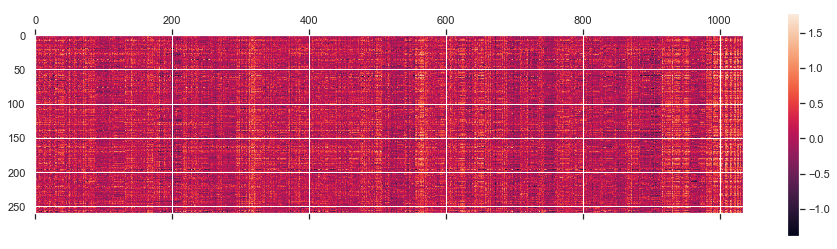

In [5]:
plt.matshow(sfnc_corr_pairs);
plt.colorbar()
plt.show()

### Regressing out the covariates from the sfnc correlation pairs

In [14]:
hd_X = sio.loadmat(os.path.join(data_dir, 'mancovan_april19', 'hd_X.mat'))
hd_X = hd_X['hd_X']

In [15]:
hd_X.shape

(261, 13)

In [18]:
a = np.linalg.inv(np.dot(hd_X.T, hd_X))
b = np.dot(hd_X, )

(13, 13)


###### Feature Selection

In [ ]:
#demographics = pd.read_excel(os.path.join(data_dir, '20160420_vcalhoun_rest_demography_cag_info_new.xls'))
# demographics.info()

In [ ]:
#demographics.cap_d_group_id2.value_counts()

In [ ]:
demographics = sio.loadmat(os.path.join(data_dir,'grouplabels_mTBI_Hans.mat')) # HANS

In [ ]:
X = sfnc_corr_pairs
#y = demographics.cap_d_group_id2 # flor
y = demographics['grouplabels'].T # Hans

In [ ]:
y = np.ravel(y)

In [ ]:
y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)

### PCA of the training data

### Fitting a simple logistic regression model

### Fitting a linear SVM

### Fitting a RBF SVM

### Fitting a Decision Tree

### Fitting a kNN

### Fitting Random Forests

# FEAST tests

In [ ]:
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC(max_iter=100000)
rbf = SVC(gamma='scale')
rf = RandomForestClassifier()
knn  = KNeighborsClassifier()

algos = [BetaGamma, DISR, CIFE, CMIM, CondMI, Condred]
num_features_list = range(5, 101, 5)
classifiers = [lr, svc, rbf, rf, knn]

acc_matrix = np.zeros((len(algos), len(num_features_list), len(classifiers)))
f1_matrix = np.zeros(acc_matrix.shape)
auc_matrix = np.zeros(f1_matrix.shape)

for i, algo in enumerate(algos):
    for j, num_features in enumerate(num_features_list):
        select_feature_index = algo(X_train, y_train, num_features)

        X_train_select = X_train[:, np.array(select_feature_index).astype(int)]
        y_train_select = y_train

        X_test_select = X_test[:, np.array(select_feature_index).astype(int)]
        y_test_select = y_test

        for k, classifier in enumerate(classifiers):
            classifier.fit(X_train_select, y_train_select)
            
            y_pred = classifier.predict(X_test_select)
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_select, y_pred)
            
            acc_matrix[i, j, k] = classifier.score(X_test_select, y_test_select)
            f1_matrix[i, j, k] = f1_score(y_test_select, y_pred)
            auc_matrix[i, j, k] = auc(false_positive_rate, true_positive_rate)

### Plots

In [ ]:
sns.set_style("darkgrid")
classifier_labels = ['lr', 'svc', 'rbf', 'rf', 'knn']
algo_labels = ['BetaGamma', 'DISR', 'CIFE', 'CMIM', 'CondMI', 'Condred']
for i in range(acc_matrix.shape[0]):
    plt.figure(i)
    for j in range(acc_matrix.shape[2]):
        plt.plot(acc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
        plt.title('Accuracy - ' + algo_labels[i])
        plt.legend()

    plt.show()
    
for i in range(acc_matrix.shape[0]):
    plt.figure(i)
    for j in range(acc_matrix.shape[2]):
        plt.plot(f1_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
        plt.title('F1 - ' + algo_labels[i])
        plt.legend()

    plt.show()
    
for i in range(acc_matrix.shape[0]):
    plt.figure(i)
    for j in range(acc_matrix.shape[2]):
        plt.plot(auc_matrix[i, :, j], label=str(classifier_labels[j]), linestyle=':')
        plt.title('AUC - ' + algo_labels[i])
        plt.legend()

    plt.show()